In [143]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import os 
import pathlib
import yfinance

In [144]:
data = pd.read_csv(pathlib.Path(os.getcwd()).parent / 'data' / 'your_portfolium.csv')

In [145]:
data.head()

,id,Date,Type,Symbol,Value
0,ETF_2025_08_21_22_38_26_382,2025-08-21,ETF,ZIG,32.32432
1,Crypto_2025_08_22_13_38_07_797,2025-08-01,Crypto,BTC-USD,60.00000


In [146]:
def plot_pie_type(data):
    subset = data.groupby(['Type'])[['Value']].agg(['count', 'sum']).reset_index()
    subset.columns = ['Type', 'count', 'sum']
    fig = go.Figure([
        go.Pie(
            labels = subset['Type'].tolist(),
            values = subset['count'].tolist(),
            customdata=subset['sum'].apply(lambda x: round(x, 2)).tolist(),
        )
    ])
    fig.update_traces(
        textinfo = 'percent+value',
        marker   = dict(
            colors = ['#e63946', '#457b9d', '#dda15e'],
        ),
        hoverlabel = dict(
            bgcolor = '#f8f9fa',
        ),
        hovertemplate = 'Type : %{label} <br>Quantity : %{value} <br>Percentage : %{percent}<br>Total : %{customdata}<extra></extra>'
    )
    fig.update_layout(
        title = dict(
            text = 'Type of Portfolium',
            font = dict(
                size = 18,
                weight = 'bold',
                color  = '#22333b'
            )
        ),
        legend = dict(
            title = dict(
                text = 'Type',
            ),
            font = dict(
                color  = '#22333b'
            )
        ),
        font = dict(
            family = 'inter, sans-serif',
        ),
        margin = dict(
            l = 50,
            b = 50,
        ),
        width = 600,
        height= 450
    )
    return fig

In [147]:
plot_pie_type(data).show()

In [148]:
data

,id,Date,Type,Symbol,Value
0,ETF_2025_08_21_22_38_26_382,2025-08-21,ETF,ZIG,32.32432
1,Crypto_2025_08_22_13_38_07_797,2025-08-01,Crypto,BTC-USD,60.00000


In [149]:
serie = yfinance.download(tickers=data['Symbol'][1], start=data['Date'][1],period='1y', interval='1d')

C:\Users\mateu\AppData\Local\Temp\ipykernel_18428\2236669284.py:1: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


In [150]:
# calcula o retorno percentual de um único ativo
def calculate_profit(series, data):
    initial_price = series['Close'].iloc[0, :][0]
    profit = ((series['Close'] - initial_price) / initial_price) * data['Value'][1]
    return round(profit, 3)

# soma os retornos de todos os ativos
def aggregate_profits(profit_list):
    total = pd.concat(profit_list, axis=1).fillna(0).sum(axis=1)
    total = total.reset_index(name='profit')
    # total['price'] = total['profit'] + data['Value'].sum()
    return round(total,3)

# pipeline principal para calcular os lucros de todos os símbolos
def compute_portfolio_profits(data):
    all_profits = []
    all_profits_pct = []
    for i in range(len(data['Symbol'])):
        series = yfinance.download(
            tickers=data['Symbol'][i],
            start=data['Date'][i],
            period='1y',
            interval='1d',
            auto_adjust=True
        )
        all_profits.append(calculate_profit(series, data))
    
    return aggregate_profits(all_profits).set_index('Date')

In [151]:
subs_ = compute_portfolio_profits(data)

[*********************100%***********************]  1 of 1 completed
C:\Users\mateu\AppData\Local\Temp\ipykernel_18428\2035150807.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

[*********************100%***********************]  1 of 1 completed
C:\Users\mateu\AppData\Local\Temp\ipykernel_18428\2035150807.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [152]:
import numpy as np

In [153]:
def serie_profit(data, subs):
    for i, row in data.iterrows():
        symbol = row['Symbol']
        date = pd.to_datetime(row['Date'])
        value = row['Value']

        if date not in subs.index:
            subs[date] = pd.Series(index=subs.columns, dtype=float)

        subs.at[date, symbol] = value
    subs = subs.ffill().fillna(0)

    return subs.sum(axis=1), subs

In [154]:
serie_, serie2_ = serie_profit(data, subs_)

In [165]:
def serie_profit_pct(data, serie2):
    sum_ = serie2.drop(columns=['profit'])
    sum_ = sum_.sum(axis=1)

    return ((data - sum_) / sum_) * 100


In [168]:
profit_pct = serie_profit_pct(serie_, serie2_)

np.float64(97.24132)

In [185]:
a = (serie_ - serie2_.drop(columns=['profit']).sum(axis=1))/serie2_.drop(columns=['profit']).sum(axis=1)

<Axes: xlabel='Date'>

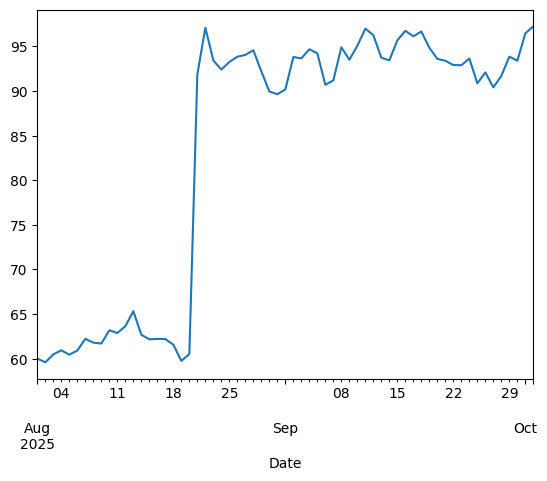

In [190]:
serie_.plot()

<Axes: xlabel='Date'>

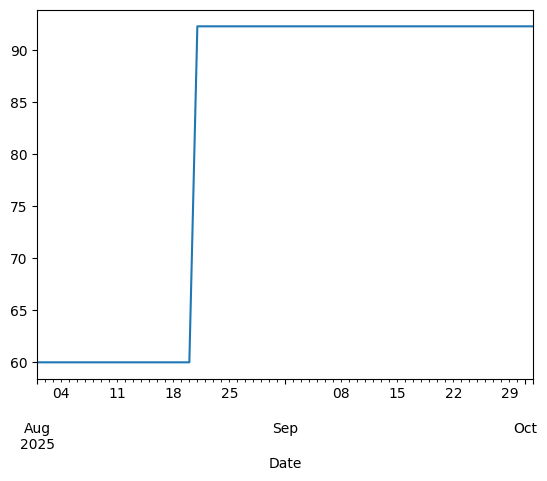

In [191]:
serie2_.drop(columns=['profit']).sum(axis=1).plot()

In [171]:
def plot_serie_profit(subs):
    fig = go.Figure([
        go.Scatter(
            x = subs.index,
            y = subs,
        )
    ])

    fig.update_traces(
        hovertemplate = 'Date : %{x} <br>Profit : %{y}<extra></extra>',
        marker = dict(
            color = '#2a9d8f'
        
        )
    )
    fig.update_layout(
        title = dict(
            text = 'Serie Profit',
            font = dict(
                size = 18,
                weight = 'bold',
                color  = '#22333b'
            )
        ),
        font = dict(
            family = 'inter, sans-serif',
        ),
        margin = dict(
            l = 50,
            b = 50,
        ),
        template = 'simple_white',
        dragmode=None
    )
    return fig

In [193]:
(65 - 60) / 60

0.08333333333333333

In [172]:
plot_serie_profit(serie_).show()

In [173]:
def plot_area_profit(subs):
    fig = go.Figure([
        go.Bar(
            x = subs.index,
            y = subs,
            customdata=subs.index.astype(str),
        )
    ])
    

    fig.update_traces(
        hovertemplate = 'Date : %{customdata} <br>Profit : %{y}<extra></extra>',
        marker = dict(
            color = [
                '#2a9d8f' if x > 0 else '#e63946' for x in subs
            ]
        )
    )
    fig.update_layout(
        title = dict(
            text = 'Serie Profit',
            font = dict(
                size = 18,
                weight = 'bold',
                color  = '#22333b'
            )
        ),
        font = dict(
            family = 'inter, sans-serif',
        ),
        margin = dict(
            l = 50,
            b = 50,
        ),
        template = 'simple_white',
        hovermode='x unified',
        dragmode=None

    )
    return fig

In [174]:

plot_area_profit(profit_pct).show()

In [163]:
serie_, subs2

(Date
 2025-08-01    60.00000
 2025-08-02    59.58000
 2025-08-03    60.47500
 2025-08-04    60.92800
 2025-08-05    60.43500
                 ...   
 2025-09-28    91.69032
 2025-09-29    93.84032
 2025-09-30    93.38932
 2025-10-01    96.45832
 2025-10-02    97.24132
 Length: 63, dtype: float64,
 Date
 2025-08-01    0.000
 2025-08-02   -0.455
 2025-08-03    0.515
 2025-08-04    1.005
 2025-08-05    0.471
               ...  
 2025-09-28   -0.687
 2025-09-29    1.170
 2025-09-30    0.816
 2025-10-01    3.822
 2025-10-02    4.326
 Freq: D, Length: 63, dtype: float64)

In [164]:
(((32.32 + 60) - 96.92332)/96.92332)*100

-4.749445231550065